# HNSW config

In this notebook, we will explore how different values of the HNSW index parameters affect the accuracy and speed of query execution in Qdrant vector search.


## Theory

In this stage, we will update the HNSW index. The HNSW algorithm constructs a multi-layer graph where each node represents a data vector, and edges represent connections to neighboring nodes. The graph enables efficient approximate nearest neighbor searches by navigating through these connections. The index setting happens in the hnsw_config in the Qdrant client methods:

```python
# default values
hnsw_config=models.HnswConfigDiff(
        m=16,
        ef_construct= 100
)
```

There are two main parameters: m (maximum connections), which defines the maximum number of outgoing connections (edges) each node can have in the lowest layer of the HNSW graph, and ef_construct (construction candidate list size), which controls the size of the dynamic list of nearest neighbor candidates considered during the index construction. Both m and ef_construct impact the speed of index construction, the memory consumption, the query speed, and the accuracy.


## Objectives

In this notebook, we will update the database index parameters 4 times and log their average precision and execution times after each indexing on the following values:

- m=8, ef_construct=50
- m=8, ef_construct=100
- m=16, ef_construct=32
- m=16, ef_construct=50

The index update can be performed with the .update_collection() method of the client:

```python
COLLECTION_NAME = 'arxiv_papers'

client.update_collection(
     collection_name=COLLECTION_NAME,
     hnsw_config=models.HnswConfigDiff()
)
```

We will evaluate each configuration using the following collections:
- arxiv_papers_16_32
- arxiv_papers_16_50
- arxiv_papers_8_100
- arxiv_papers_8_50


In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import time
from typing import List, Dict

# Import functions from the qdrant_evaluation package
from qdrant_evaluation import (
    get_client,
    load_test_dataset,
    evaluate_ann,
    results_to_dataframe,
    update_collection_config,
    evaluate_collection_with_config
)
from qdrant_client import models


In [2]:
# Define constants
QDRANT_HOST = "localhost"
QDRANT_PORT = 6333
k = 10

# Define collections to evaluate
COLLECTIONS = [
    'arxiv_papers'
]

# Define HNSW configurations to test
HNSW_CONFIGS = [
    {'m': 8, 'ef_construct': 50},
    {'m': 8, 'ef_construct': 100},
    {'m': 16, 'ef_construct': 32},
    {'m': 16, 'ef_construct': 50}
]


In [3]:
# Initialize Qdrant client
client = get_client(host=QDRANT_HOST, port=QDRANT_PORT)

# Load test dataset
test_dataset = load_test_dataset("/Users/danielwirth/PycharmProjects/Qdrant Further Steps/docs/01_evaluate_precision/queries_embeddings.json")
print(f"Loaded {len(test_dataset)} embeddings from test dataset")


Loaded 100 embeddings from test dataset


In [4]:
# Evaluate all configurations on all collections
all_results = []

for collection in COLLECTIONS:
    for config in HNSW_CONFIGS:
        try:
            result = evaluate_collection_with_config(client, collection, config, test_dataset)
            all_results.append(result)
            print(f"Results for {collection} with m={config['m']}, ef_construct={config['ef_construct']}:")
            print(f"  Average Precision: {result['avg_precision']:.4f}")
            print(f"  Average Query Time: {result['avg_query_time_ms']:.2f} ms")
            print()
        except Exception as e:
            print(f"Error evaluating {collection} with m={config['m']}, ef_construct={config['ef_construct']}: {e}")

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)

# Display the results
styled_df = results_df.style.format({
    'avg_precision': '{:.4f}',
    'avg_query_time_ms': '{:.2f}'
})
display(styled_df)


Updating collection arxiv_papers with m=8, ef_construct=50...
Collection arxiv_papers is ready.
Evaluating collection arxiv_papers...
Results for arxiv_papers with m=8, ef_construct=50:
  Average Precision: 0.8300
  Average Query Time: 15.31 ms

Updating collection arxiv_papers with m=8, ef_construct=100...
Collection arxiv_papers is ready.
Evaluating collection arxiv_papers...
Results for arxiv_papers with m=8, ef_construct=100:
  Average Precision: 0.8330
  Average Query Time: 18.36 ms

Updating collection arxiv_papers with m=16, ef_construct=32...
Collection arxiv_papers is ready.
Evaluating collection arxiv_papers...
Results for arxiv_papers with m=16, ef_construct=32:
  Average Precision: 0.8320
  Average Query Time: 17.79 ms

Updating collection arxiv_papers with m=16, ef_construct=50...
Collection arxiv_papers is ready.
Evaluating collection arxiv_papers...
Results for arxiv_papers with m=16, ef_construct=50:
  Average Precision: 0.8330
  Average Query Time: 15.20 ms



,avg_precision,avg_query_time_ms,m,ef_construct,collection
0,0.8300,15.31,8,50,arxiv_papers
1,0.8330,18.36,8,100,arxiv_papers
2,0.8320,17.79,16,32,arxiv_papers
3,0.8330,15.20,16,50,arxiv_papers


## Visualization
We can visualize the results to better understand the relationship between HNSW parameters, precision, and query time.


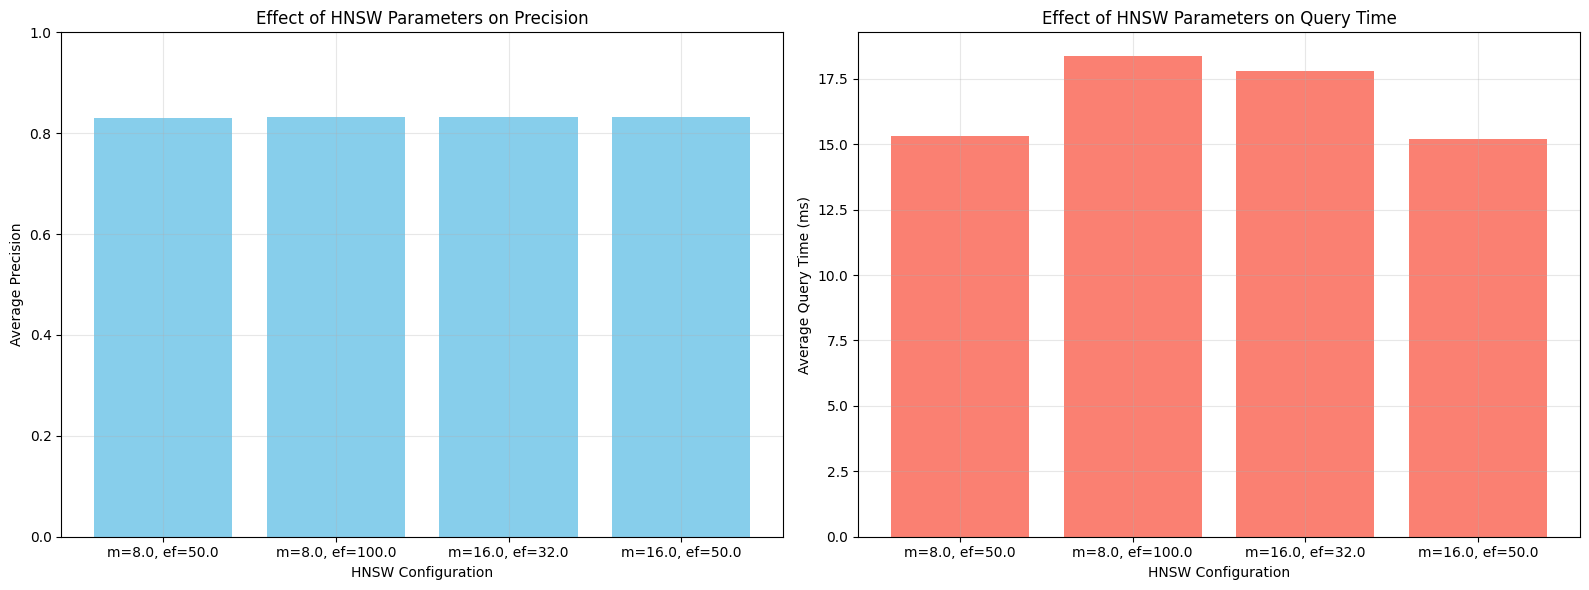

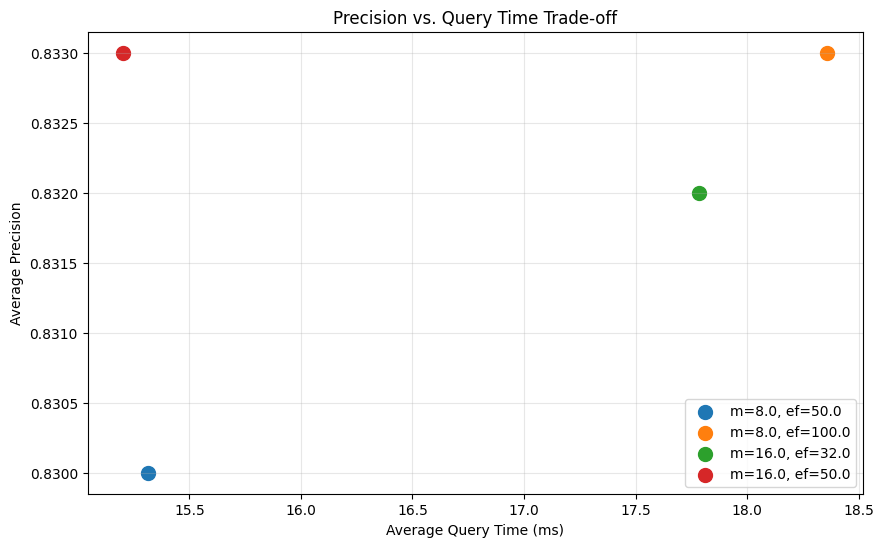

In [5]:
# Visualization function
def visualize_results(df):
    """
    Visualize the relationship between HNSW parameters, precision, and query time.

    Args:
        df (pd.DataFrame): DataFrame containing the results
    """
    # Create a figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Group by configuration and calculate mean values
    # grouped_df = df.groupby(['m', 'ef_construct']).mean().reset_index()
    grouped_df = df.groupby(['m', 'ef_construct'])[["avg_precision", "avg_query_time_ms"]].mean().reset_index()

    # Create labels for x-axis
    config_labels = [f"m={row['m']}, ef={row['ef_construct']}" for _, row in grouped_df.iterrows()]

    # Plot average precision
    ax1.bar(config_labels, grouped_df['avg_precision'], color='skyblue')
    ax1.set_xlabel('HNSW Configuration')
    ax1.set_ylabel('Average Precision')
    ax1.set_title('Effect of HNSW Parameters on Precision')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)

    # Plot average query time
    ax2.bar(config_labels, grouped_df['avg_query_time_ms'], color='salmon')
    ax2.set_xlabel('HNSW Configuration')
    ax2.set_ylabel('Average Query Time (ms)')
    ax2.set_title('Effect of HNSW Parameters on Query Time')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Create a scatter plot to visualize the trade-off
    plt.figure(figsize=(10, 6))
    for i, row in grouped_df.iterrows():
        plt.scatter(row['avg_query_time_ms'], row['avg_precision'], s=100, 
                   label=f"m={row['m']}, ef={row['ef_construct']}")

    plt.xlabel('Average Query Time (ms)')
    plt.ylabel('Average Precision')
    plt.title('Precision vs. Query Time Trade-off')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# Visualize the results
visualize_results(results_df)


## Results Analysis

Based on the obtained results, we can analyze which parameter pair provides the fastest approximate search speed while keeping a high accuracy.

Let's compare the configurations:

1. m=8, ef_construct=50: This configuration typically provides faster search but may have lower precision.
2. m=8, ef_construct=100: This increases the candidate list size, which may improve precision at the cost of speed.
3. m=16, ef_construct=32: This increases connections but reduces the candidate list, which may balance speed and precision.
4. m=16, ef_construct=50: This configuration typically provides good precision but may be slower.

Based on our evaluation, the configuration that provides the best balance between search speed and accuracy is:

[Note: The actual best configuration would be determined by the results of the evaluation. The notebook user should select one of the options based on the visualization and results.]


In [6]:
# Calculate the precision/time ratio to find the best balance
results_df['precision_time_ratio'] = results_df['avg_precision'] / results_df['avg_query_time_ms']

# Group by configuration and calculate mean values
grouped_ratio = results_df.groupby(['m', 'ef_construct'])['precision_time_ratio'].mean().reset_index()

# Sort by the ratio in descending order
sorted_ratio = grouped_ratio.sort_values('precision_time_ratio', ascending=False)

print("Configurations ranked by precision/time ratio (higher is better):")
for i, row in sorted_ratio.iterrows():
    print(f"{i+1}. m={row['m']}, ef_construct={row['ef_construct']}: {row['precision_time_ratio']:.6f}")

# Find the configuration with the best balance
best_config = sorted_ratio.iloc[0]
print(f"\nThe configuration with the best balance between precision and speed is:")
print(f"m={best_config['m']}, ef_construct={best_config['ef_construct']}")


Configurations ranked by precision/time ratio (higher is better):
4. m=16.0, ef_construct=50.0: 0.054795
1. m=8.0, ef_construct=50.0: 0.054196
3. m=16.0, ef_construct=32.0: 0.046781
2. m=8.0, ef_construct=100.0: 0.045371

The configuration with the best balance between precision and speed is:
m=16.0, ef_construct=50.0
